# Muestreo por rechazo

Para estimar las probabilidades a partir de una red Bayesiana, se puede utilizar inferencia por aproximación, a partir de generar un conjunto de muestras de los eventos de interés. Un algoritmo para hacer este tipo de inferencia es el de muestreo por rechazo. Este es un algoritmo simple que toma muestras aleatorias a partir de la red bayesiana y rechaza aquellas muestras que no respondan a la evidencia.

Presentamos la aplicación del muestreo por rechazo a una red bayesiana que representa el problema de Monty Hall. El objetivo del muestreo por rechazo será que, dada la evidencia correspondiente a la elección de puertas del invitado y del presentador (Monty), podamos determinar la probabilidad de que en una puerta se encuentre o no el premio.

In [1]:
import numpy as np
from bayesian_monty import MontyNetwork

np.random.seed(10)

#Guarda la estructura de red Bayesiana
bn = MontyNetwork()

### Muestreo de prior

El muestreo de prior es un método de muestreo directo que genera una muestra a partir de una red bayesiana. En este caso, se toma una muestra aleatoria de las puertas elegidas en cada variable (invitado, monty y la puerta del premio). Estas muestras se toman en base a las probabilidades de la red. Generalmente, el muestre de variables se hace en orden topológico.

In [2]:
def prior_sample(bn):
    """Muestreo de prior genera una muestra aleatoria de un evento"""
    #Guarda la muestra generada
    x = np.zeros(3, dtype=int)
    #Genera muestra de la primera variable
    x[0] = np.random.choice([0,1,2], p=bn.X0.cpt)
    #Genera muestra de la segunda variable
    x[1] = np.random.choice([0,1,2], p=bn.X1.cpt)
    #Genera muestra de la tercera variable con base en las muestras previas
    x[2] = np.random.choice([0,1,2], p=bn.X2.cpt[x[1],:,x[0]])
    
    return x

Aplicando la función de <tt>prior_sample</tt> lo que obtendremos es una muestra aleatoria donde cada entrada será la elección de una de las puertas para cada variable $X_0, X_1$ y $X_2$ en este orden.

In [3]:
#Genera una muestra
print(prior_sample(bn))

[2 0 1]


## Método de muestreo por rechazo

El muestre por rechazo se basa en el muestreo de prior. Es un algoritmo muy sencillo que realizará los siguientes pasos:

1. Generará un vector $C$ para los valores de la variable de interés, que en este caso es $X_1$, que corresponde la variable del premio.
2. Tomará una muestra aleatoria en base al muestreo de prior.
3. Si esta muestra es consistente con la evidencia (toma los valores que se han determinado para las otras variables), entonces sumará 1 al valor correspondiente en $C$.
4. Repetirá el proceso $N$ veces, para obtener $N$ muestras.
5. Normaliza $C$ dividiendo entre la suma total de los conteos en $C$ para obtener una probabilidad y regresa $C$.

Por tanto, lo que obtendremos será una inferencia de las probabilidades para la variable determinada; en este caso, tendremos la probabilidad de que dada la elección previa de un invitado y la elección del presentador, el premio se encuentre detrás de alguna de las puertas.

In [4]:
def rejection_sampling(bn, guest, monty, N=100):
    """Algoritmo de muestreo por rechazo"""
    #Inicializa la variable
    C = np.zeros(3)
    for j in range(0, N):
        #Genera una muestra aleatoria
        x = prior_sample(bn)
        #Rechaza las muestras que no cuentan con la evidencia
        if x[0]==guest and x[2]==monty:
            C[x[1]] += 1
            
    return C/C.sum()

En general, esperamos que entre mayor sea el número de muestras, más cercano sea el valor obtenido por el muestreo por rechazo a las probabilidades reales. Esto se debe a la ley de los grandes números, la cuál señala que:

$$\lim_{N\to \infty} \frac{1}{N} X_i  = \mathbb{E}\big[ X \big]$$

Donde la convergencia es en probabilidad. De tal forma que, entre más grande sea $N$, más podremos acercarnos al valor real. Aunque muchas veces, la convergencia puede darse antes. En este caso tomamos 1000 muestras.

In [5]:
#Genera la inferencia
pX1 = rejection_sampling(bn, guest=1,monty=2, N=1000)

#Imprime los resultados
for i in range(3):
    print('p(X1={}|X0=1, X2=2)={}'.format(i, np.round(pX1[i],2)))

p(X1=0|X0=1, X2=2)=0.76
p(X1=1|X0=1, X2=2)=0.24
p(X1=2|X0=1, X2=2)=0.0


Los valores de las probabilidades se acercan mucho a los valores estimados de forma exacta. La puerta elegida por el presentador siempre tendrá probabilidad 0 (pues siempre elegirá una puerta que no tenga el premio), mientras que la puerta elegida por el invitado tendrá probabilidad $\frac{1}{3}$, y la puerta restante probabilidad de $\frac{2}{3}$. En este caso, vemos que con 1000 muestras hemos aproximado suficiente los valores reales.

### Convergencia de la inferencia

Finalmente, podemos ver como se da la convergencia de esta inferencia a través del número de muestras:

In [6]:
#Obtiene probabilidades
p0, p1, p2 = [], [], []
C = np.zeros(3)
for j in range(1,1000):
    x = prior_sample(bn)
    if x[0]==1 and x[2]==2:
        C[x[1]] += 1
    
    p0.append((C/C.sum())[0])
    p1.append((C/C.sum())[1])
    p2.append((C/C.sum())[2])

Como se puede observar, entre más crece el número de muestras, más se acercan las probabilidades estimadas por el muestreo por rechazo a las probabilidades reales, estabilizándose cerca de los valores de $\frac{2}{3}$ y $\frac{1}{3}$.

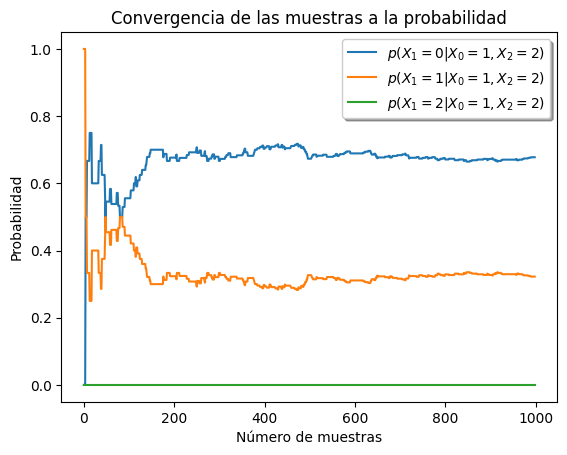

In [7]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(p0, label='$p(X_1=0|X_0=1,X_2=2)$')
ax.plot(p1, label='$p(X_1=1|X_0=1,X_2=2)$')
ax.plot(p2, label='$p(X_1=2|X_0=1,X_2=2)$')
legend = ax.legend(loc='upper right', shadow=True)
plt.title('Convergencia de las muestras a la probabilidad')
plt.xlabel('Número de muestras')
plt.ylabel('Probabilidad')
plt.show()